In [1]:
!pwd
import ipython_genutils

/Users/air/Desktop/DS_projects/Failed_orders


# Project: Insights from failed orders

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#EDA">Eploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id="intro"></a>
## Introduction

Gett, previously known as GetTaxi, is an Israeli-developed technology platform solely focused on corporate Ground Transportation Management (GTM). They have an application where clients can order taxis, and drivers can accept their rides (offers). At the moment, when the client clicks the Order button in the application, the matching system searches for the most relevant drivers and offers them the order. In this task, we would like to investigate some matching metrics for orders that did not completed successfully, i.e., the customer didn't end up getting a car.

It begins by
- building up a distribution of orders accordig to reasons for failure: cancellations before and after driver assignment, and the reason for order rejection, analysing the resulting plot to see which category has the highest number of orders.
- Ploting the distribution of failed orders by hours to identify a thrend of certain hours having abnormally high proportion of one category or another. and also find out what hours are the biggest fails and how that can be explained.
- Plotting the average time to cancellation with and without driver, by the hour to see it there are any outliers within the data and then proceed to remove them and draw further conclusion from the data.
- Plotting the distributio of average ETA by hours and explaining any thrend establisged.
- calculating how many size 8 hexes contain 80% of all orders from the original data sets and visualising the hexes.


## Data Description
We have two data sets: `data_orders` and `data_offers`, both being stored in a CSV format. The `data_orders` data set contains the following columns:

- `order_datetime` - time of the order
- `origin_longitude` - longitude of the order
- `origin_latitude` - latitude of the order
- `m_order_eta` - time before order arrival
- `order_gk` - order number
- `order_status_key` - status, an enumeration consisting of the following mapping:
- `4` - cancelled by client,
- `9` - cancelled by system, i.e., a reject
- `is_driver_assigned_key` - whether a driver has been assigned
- `cancellation_time_in_seconds` - how many seconds passed before cancellation

The `data_offers` data set is a simple map with 2 columns:

- `order_gk` - order number, associated with the same column from the - `orders` data set
- `offer_id` - ID of an offer

<a id="wrangling"></a>
## Data wrangling

Pandas library is used to load the CSVs into a DataFrame

In [2]:
import pandas as pd, numpy as np

In [3]:
orders = pd.read_csv('datasets/data_orders.csv')
offers = pd.read_csv('datasets/data_offers.csv')

In [4]:
# geta sense of the number of entries and features
orders.shape

(10716, 8)

In [5]:
# investigate missing data
orders.isnull().sum()/orders.shape[0]

order_datetime                   0.000000
origin_longitude                 0.000000
origin_latitude                  0.000000
m_order_eta                      0.737402
order_gk                         0.000000
order_status_key                 0.000000
is_driver_assigned_key           0.000000
cancellations_time_in_seconds    0.318122
dtype: float64

m_order_eta and cancellations_time_in_seconds have 73% and 32% of entire data missing respectively

In [6]:
#take a look at samples from the data, while specilfying random_state
# key to enfore determinism(get same sample always)
orders.sample(10,random_state=13)

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
339,15:42:16,-0.922114,51.451058,538.0,3000627981250,4,1,37.0
7514,17:49:27,-0.969326,51.433188,658.0,3000587381462,4,1,109.0
7918,00:17:44,-0.948534,51.440262,NaN,3000600112586,9,0,NaN
6143,08:47:39,-0.956305,51.443311,297.0,3000582165839,4,1,545.0
8916,03:24:32,-0.974736,51.454823,60.0,3000557660390,4,1,57.0
1064,08:15:48,-0.963172,51.454195,NaN,3000623443068,9,0,NaN
5711,22:36:55,-0.956702,51.443059,NaN,3000627506572,9,0,NaN
2326,15:24:17,-1.033644,51.445660,297.0,3000578650723,4,1,19.0
1966,03:23:53,-0.944338,51.441401,NaN,3000595270612,4,0,203.0
5675,19:15:22,-0.973507,51.449443,NaN,3000623717383,4,0,232.0


In [7]:
#inspect the data format and missing numbers in dataset
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_datetime                 10716 non-null  object 
 1   origin_longitude               10716 non-null  float64
 2   origin_latitude                10716 non-null  float64
 3   m_order_eta                    2814 non-null   float64
 4   order_gk                       10716 non-null  int64  
 5   order_status_key               10716 non-null  int64  
 6   is_driver_assigned_key         10716 non-null  int64  
 7   cancellations_time_in_seconds  7307 non-null   float64
dtypes: float64(4), int64(3), object(1)
memory usage: 669.9+ KB


In [8]:
# change order_datetime from string to datetime format
orders.order_datetime = pd.to_datetime(orders.order_datetime)
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_datetime                 10716 non-null  datetime64[ns]
 1   origin_longitude               10716 non-null  float64       
 2   origin_latitude                10716 non-null  float64       
 3   m_order_eta                    2814 non-null   float64       
 4   order_gk                       10716 non-null  int64         
 5   order_status_key               10716 non-null  int64         
 6   is_driver_assigned_key         10716 non-null  int64         
 7   cancellations_time_in_seconds  7307 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(3)
memory usage: 669.9 KB


In [9]:
orders.sample(10,random_state=13)

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
339,2022-12-23 15:42:16,-0.922114,51.451058,538.0,3000627981250,4,1,37.0
7514,2022-12-23 17:49:27,-0.969326,51.433188,658.0,3000587381462,4,1,109.0
7918,2022-12-23 00:17:44,-0.948534,51.440262,NaN,3000600112586,9,0,NaN
6143,2022-12-23 08:47:39,-0.956305,51.443311,297.0,3000582165839,4,1,545.0
8916,2022-12-23 03:24:32,-0.974736,51.454823,60.0,3000557660390,4,1,57.0
1064,2022-12-23 08:15:48,-0.963172,51.454195,NaN,3000623443068,9,0,NaN
5711,2022-12-23 22:36:55,-0.956702,51.443059,NaN,3000627506572,9,0,NaN
2326,2022-12-23 15:24:17,-1.033644,51.445660,297.0,3000578650723,4,1,19.0
1966,2022-12-23 03:23:53,-0.944338,51.441401,NaN,3000595270612,4,0,203.0
5675,2022-12-23 19:15:22,-0.973507,51.449443,NaN,3000623717383,4,0,232.0


In [10]:
# geta sense of the number of entries and features
offers.shape

(334363, 2)

In [11]:
#investigate missing values
offers.isnull().sum()

order_gk    0
offer_id    0
dtype: int64

In [12]:
# investigate data types
offers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334363 entries, 0 to 334362
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   order_gk  334363 non-null  int64
 1   offer_id  334363 non-null  int64
dtypes: int64(2)
memory usage: 5.1 MB


In [13]:
#  view samples of the data
offers.sample(10,random_state=13)

,order_gk,offer_id
187474,3000596421448,300051566747
147870,3000628807245,300052187786
77639,3000623790996,300051869966
292490,3000625092591,300051972070
38540,3000631156163,300052331409
257777,3000585091766,300051103545
66947,3000627383151,300052079810
253560,3000552920878,300050611078
50980,3000617526191,300051721402
167153,3000628683796,300052174189


In [14]:
# get common columns in both dataset
all_columns = pd.Series(list(offers)+list(orders))
all_columns[all_columns.duplicated()]

6    order_gk
dtype: object

Merge the two datasets for easier wrangling and analysis using the `merge()` method, by merging on `order_gk` column and specifying how the merge is carried our by using the `inner` parameter

In [15]:
df = orders.merge(offers,how='inner',on='order_gk')
df.sample(10,random_state=13)

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,offer_id
30062,2022-12-23 22:43:23,-0.924026,51.436252,NaN,3000590756372,4,0,111.0,300051333862
30869,2022-12-23 22:41:15,-0.977636,51.430590,NaN,3000593796847,4,0,5.0,300051443528
10035,2022-12-23 19:26:41,-0.924773,51.428314,538.0,3000588731002,4,1,119.0,300051234376
8385,2022-12-23 12:28:59,-0.974722,51.481711,NaN,3000579875810,9,0,NaN,300050940707
10297,2022-12-23 08:05:17,-0.931454,51.452609,NaN,3000557112002,4,0,99.0,300050753487
11538,2022-12-23 23:33:36,-0.945348,51.427105,NaN,3000625141304,9,0,NaN,300051974606
19922,2022-12-23 01:37:12,-0.956911,51.449421,NaN,3000595870780,9,0,NaN,300051550721
10725,2022-12-23 20:06:31,-0.945261,51.444823,167.0,3000588081641,4,1,231.0,300051199054
15351,2022-12-23 17:42:30,-0.978202,51.455502,NaN,3000598661555,4,0,51.0,300051622044
4149,2022-12-23 10:55:25,-0.953072,51.451130,NaN,3000556096214,4,0,206.0,300050737050


It may be prudent to improve the data quality by making the `order_status_key` and `is_driver_assigned_key` more contextualized by assigning `1`s in `is_driver_assigned` with `Yes` and the `0`s with `No`. And also assigning `4`s in `order_status_key` with `Client_cancelled` and `9`s with `System_rejected`

In [16]:
df['is_driver_assigned_key'] = np.where(df['is_driver_assigned_key']==1,'Yes','No')
df['order_status_key'] = np.where(df['order_status_key']==4,'Client_cancelled','System_rejected')

In [17]:
# df.query('order_status_key=="Client_cancelled"')

Rename columns to be more informative

In [18]:
df.columns

Index(['order_datetime', 'origin_longitude', 'origin_latitude', 'm_order_eta',
       'order_gk', 'order_status_key', 'is_driver_assigned_key',
       'cancellations_time_in_seconds', 'offer_id'],
      dtype='object')

In [19]:
cols = {'order_datetime':'order_time',
        'origin_longitude':'longitude',
        'origin_latitude':'latitude',
         'm_order_eta':'ETA',
         'order_gk':'order_id',
         'order_status_key':'order_status',
         'is_driver_assigned_key':'is_driver_assigned',
        'cancellations_time_in_seconds':'cancellation_time'}

df.rename(columns=cols,inplace=True)

In [20]:
df

,order_time,longitude,latitude,ETA,order_id,order_status,is_driver_assigned,cancellation_time,offer_id
0,2022-12-23 18:08:07,-0.978916,51.456173,60.0,3000583041974,Client_cancelled,Yes,198.0,300050983403
1,2022-12-23 20:57:32,-0.950385,51.456843,NaN,3000583116437,Client_cancelled,No,128.0,300050986179
2,2022-12-23 20:57:32,-0.950385,51.456843,NaN,3000583116437,Client_cancelled,No,128.0,300050986174
3,2022-12-23 20:57:32,-0.950385,51.456843,NaN,3000583116437,Client_cancelled,No,128.0,300050986180
4,2022-12-23 12:07:50,-0.969520,51.455544,477.0,3000582891479,Client_cancelled,Yes,46.0,300050976275
...,...,...,...,...,...,...,...,...,...
31263,2022-12-23 12:44:11,-0.975372,51.457846,NaN,3000597886155,Client_cancelled,No,43.0,300051590196
31264,2022-12-23 12:42:52,-0.975372,51.457846,NaN,3000597886140,Client_cancelled,No,44.0,300051590176
31265,2022-12-23 13:11:35,-0.975372,51.457846,NaN,3000599186906,Client_cancelled,No,36.0,300051648809
31266,2022-12-23 13:17:21,-0.972926,51.457693,60.0,3000599187034,Client_cancelled,Yes,34.0,300051648910


<a id="EDA"></a>

## Exploratory Data Analysis

## **Question 1**

**Building up a distribution of orders accordig to reasons for failure: cancellations before and after driver assignment, and the reason for order rejection, analysing the resulting plot to see which category has the highest number of orders.**

This is evalutated by using pandas groupby method to group the table by the columns `is_driver_assigned` and `order_status` and counting the number of orders in `order_id` 

In [41]:
cancellations = df.groupby(['is_driver_assigned','order_status'])['order_id'].count()
cancellations

is_driver_assigned  order_status    
No                  Client_cancelled    13435
                    System_rejected      9469
Yes                 Client_cancelled     8360
                    System_rejected         4
Name: order_id, dtype: int64

It is obserevd that a high number of clients cancelled their order before a driver was assigned, implying that probably customers had dwaited too long to be assigned a driver and decided on other alternaive transport means. There are `13435` order cancelled by the client, and `9464` rejected by the system. While there are `8360` orders cancelled by the clients after driver was assigned and only `4` rejected by the system

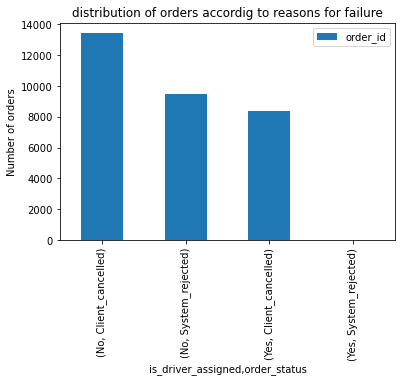

In [22]:
_=cancellations.plot(kind='bar',legend=True,subplots=False,\
                   ylabel='Number of orders',\
                   title='distribution of orders accordig to reasons for failure');

## **Question 2**

**Ploting the distribution of failed orders by hours to identify a thrend of certain hours having abnormally high proportion of one category or another. and also find out what hours are the biggest fails and how that can be explained**

This further builds on the previous question by looking at the time when these fails occured in an effort establish a thrend. To do this the hour of day is extracted from the datetime colums and the failed orders are counted by hour.  


In [23]:
# Extract hour fro datetime column
df['order_hour'] = df.order_time.dt.hour

In [24]:
df.sample(4,random_state=13)

,order_time,longitude,latitude,ETA,order_id,order_status,is_driver_assigned,cancellation_time,offer_id,order_hour
30062,2022-12-23 22:43:23,-0.924026,51.436252,NaN,3000590756372,Client_cancelled,No,111.0,300051333862,22
30869,2022-12-23 22:41:15,-0.977636,51.430590,NaN,3000593796847,Client_cancelled,No,5.0,300051443528,22
10035,2022-12-23 19:26:41,-0.924773,51.428314,538.0,3000588731002,Client_cancelled,Yes,119.0,300051234376,19
8385,2022-12-23 12:28:59,-0.974722,51.481711,NaN,3000579875810,System_rejected,No,NaN,300050940707,12


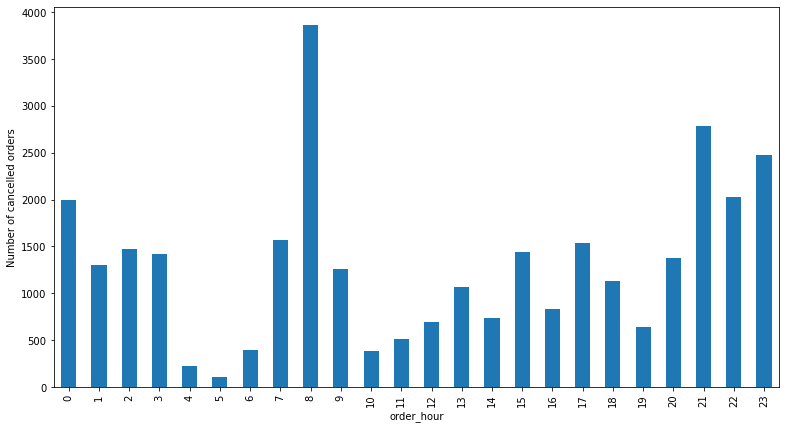

In [25]:
_ = df.groupby('order_hour')['order_id'].count().\
            plot(kind='bar',figsize=(13,7),ylabel='Number of cancelled orders'),


From the bar chart above , it is seen that the biggest fails occurred at `8:00`,followed by `21:00` and `23:00`

Failed orders are further investigated by hour by category, to obtain deeper insights into the cancelations by category.

In [26]:
q2 = df.groupby(['order_hour','is_driver_assigned','order_status'])['order_id'].count()
q2                             

order_hour  is_driver_assigned  order_status    
0           No                  Client_cancelled     957
                                System_rejected      706
            Yes                 Client_cancelled     326
                                System_rejected        4
1           No                  Client_cancelled     633
                                                    ... 
22          No                  System_rejected      660
            Yes                 Client_cancelled     415
23          No                  Client_cancelled    1144
                                System_rejected      883
            Yes                 Client_cancelled     444
Name: order_id, Length: 73, dtype: int64

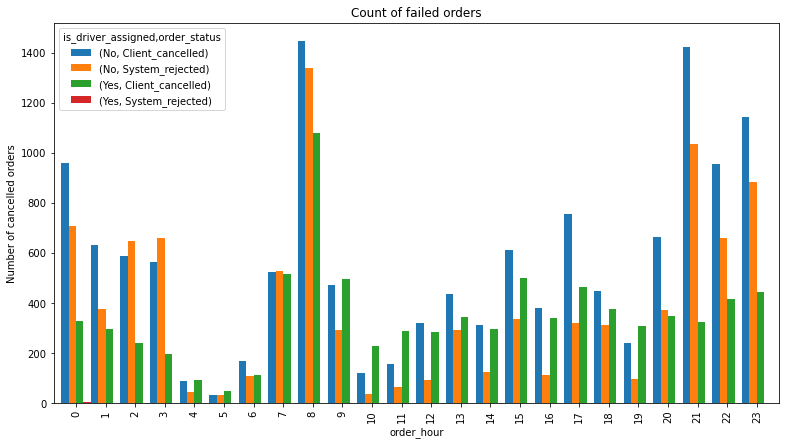

In [27]:
q2.reset_index().pivot(index='order_hour',
         columns=['is_driver_assigned','order_status'],
         values = 'order_id').plot(kind='bar',xticks=range(0,24),
                            figsize=(13,7),width=1,
                            title='Count of failed orders',
                            ylabel= 'Number of cancelled orders');

From the breakdown of the above bar chart, it is seen that the highes cancelation accross all categories indeed occurred at 8:00.  

## **Question 3**

**Ploting the average time to cancellation with and without driver, by the hour to see it there are any outliers within the data and then proceed to remove them and draw further conclusion from the data**

Again, the same approached as taken with the previous questions are employed. the dataframe is aggregated by the `order_hour` and `is_driver_assigned`, and then `cancelletion_time` is aggregated with the `mean` function  

In [28]:
q3 = df.groupby(['order_hour','is_driver_assigned'])['cancellation_time'].mean()
q3

order_hour  is_driver_assigned
0           No                    115.126437
            Yes                   276.082822
1           No                    100.593997
            Yes                   296.312081
2           No                    121.305461
            Yes                   301.466667
3           No                    129.182301
            Yes                   368.682051
4           No                    100.733333
            Yes                   245.250000
5           No                    102.838710
            Yes                   156.617021
6           No                    202.952663
            Yes                   225.508772
7           No                    141.177820
            Yes                   177.640232
8           No                    132.625432
            Yes                   172.896296
9           No                    138.014894
            Yes                   230.821862
10          No                     93.795082
            Yes         

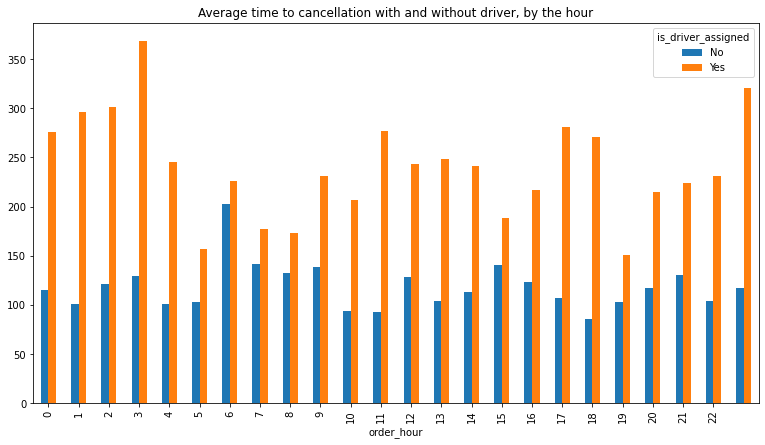

In [29]:
q3.reset_index().pivot(index='order_hour',
         columns='is_driver_assigned',
         values='cancellation_time').plot(kind='bar',
                                          xticks=range(0,23),
                                          figsize=(13,7),
                                          title='Average time to cancellation with and without driver, by the hour');

The average time to cancellation is higher on with an assigned driver than those without assigned driver for each hour without exception.The peak occurred at 3:00. At this time there are a lot of client cancellations, so a logical explanation would be that clients have waited too long for the driver.

## **Question 4**
Plotting the distributio of average ETA by hours and explaining any thrend establisged.

We simply group-by the DataFrame on the order hour, and aggregate the m_order_eta column with a mean function. Then, we plot the resulting DataFrame. The result is in the cell immediately below.

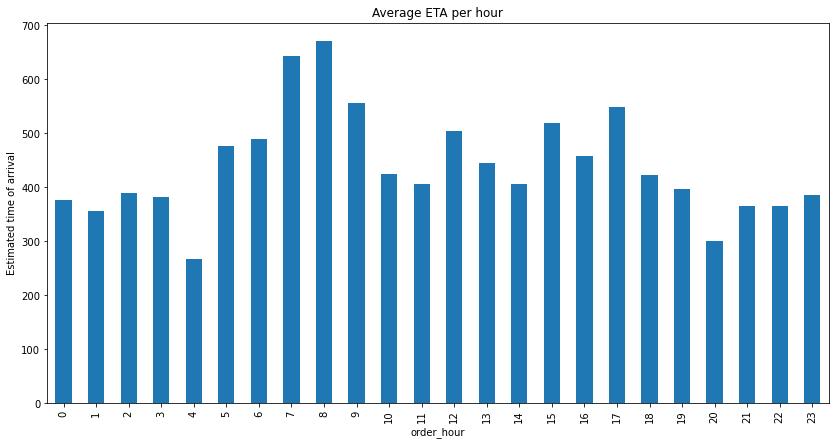

In [43]:
_ = df.groupby(by="order_hour")["ETA"].mean().plot(kind='bar',figsize=(14, 7),
                     xticks=range(0, 24),
                     ylabel='Estimated time of arrival',
                     title="Average ETA per hour")

The bar chats very closely matches the count of failed orders per hour, indicating that the number of failed orders increases as the average waiting time of the client increases.

## **Question 5**
**calculating how many size 8 hexes contain 80% of all orders from the original data sets and visualising the hexes**

In [31]:
import h3
import folium

In [32]:
df["hex_id"] = df.apply(
    func=lambda row: h3.geo_to_h3(lat=row["latitude"], lng=row["longitude"],\
                                  resolution=8), axis=1)


In [33]:
grouped_q5 = df.groupby(by='hex_id')["order_id"].count()
grouped_q5.shape

(139,)

In [34]:
grouped_q5 = grouped_q5.reset_index()
grouped_q5.sample(n=5,random_state=42)

,hex_id,order_id
135,88195d74d1fffff,1
66,88195d2a33fffff,12
31,88195d2941fffff,52
118,88195d2b5dfffff,31
42,88195d2961fffff,5


To find the number of hexes that contain 80% of the orders, we will apply a cumulative percentage operation over the order_id count column in the grouped_q5 DataFrame. This consists of the following steps:
1. Sort the DataFrame by the count. 
2. Find the total number (sum) of failed orders. 
3. Apply the method cumsum to find the cumulative sum of the order count column. 
4. Divide by the total sum to generate percentages. 
5. Filter to find the row that is closest to 80%.

In [35]:
grouped_q5 = grouped_q5.sort_values(by="order_id") # 1
total_orders = grouped_q5["order_id"].sum() # 2
grouped_q5["cum_sum"] = grouped_q5["order_id"].cumsum() # 3
grouped_q5["cum_perc"] = 100 * grouped_q5["cum_sum"] / total_orders # 4
grouped_q5[grouped_q5["cum_perc"] <= 80] # 5

,hex_id,order_id,cum_sum,cum_perc
137,88195d74d5fffff,1,1,0.003198
135,88195d74d1fffff,1,2,0.006396
79,88195d2aebfffff,1,3,0.009594
11,88195d282bfffff,1,4,0.012793
122,88195d3993fffff,1,5,0.015991
...,...,...,...,...
61,88195d2a27fffff,1295,15628,49.980811
20,88195d284dfffff,1937,17565,56.175643
91,88195d2b19fffff,1960,19525,62.444032
87,88195d2b11fffff,2191,21716,69.451196


There are 137 rows in the final output, and 139 rows in the original grouped DataFrame, meaning that 137 hexagons contain around 80% of data, and only 2 hexagons contain the other 20%!

In [36]:
map = folium.Map(location=[df["latitude"].mean(), df["longitude"].mean()],
 zoom_start=8.5, # after a bit of experimentation, we thought this presents the map best
 tiles="cartodbpositron")

In [37]:
import json
import geojson
def to_geojson(row):    
    """
    Transform hex_id into a geojson object.
    """
    geometry = {
    "type": "Polygon",
    "coordinates": [h3.h3_to_geo_boundary(h=row["hex_id"], geo_json=True)]
                }
    result = geojson.Feature(id=row["hex_id"], geometry=geometry, properties={"order_id":row['order_id']})
    return result
                                                                                                                                                
geojsons = grouped_q5.apply(func=to_geojson, axis=1).values.tolist()
geojson_str: str = json.dumps(geojson.FeatureCollection(geojsons))
                                                                              

In [38]:

import matplotlib
# instantiate a colormap object for better visualisation
colormap = matplotlib.cm.get_cmap(name="plasma")
max_order_gk = grouped_q5["order_id"].max()
min_order_gk = grouped_q5["order_id"].min()


In [56]:
_ = folium.GeoJson(data=geojson_str, style_function=lambda f: {
 "fillColor": matplotlib.colors.to_hex(
 colormap((f["properties"]["order_id"]-min_order_gk)/(max_order_gk - min_order_gk))),
 "color": "black",
 "weight": 1,
 "fillOpacity": 0.7
}).add_to(map)

In [57]:
map

<a id="conclusions"></a>
## Conclusion

It is observed that a high number of clients cancelled their order before a driver was assigned, implying that customers probably had waited too long to be assigned a driver and decided on other alternaive transport means.

It is evident that the biggest fails occurred at `8:00`,followed by `21:00` and `23:00`. And this evident accross all categories.

The average time to cancellation is higher with an assigned driver than those without assigned driver for each hour without exception.The peak occurred at 3:00. At this time there are a lot of client cancellations, so a logical explanation would be that clients have waited too long for the driver.

Order cancellation increases with increasing ETAs, with the highest ETAs happening at 8:00. It is therefore not surprising that the highest concellations happen at 8:00 as evident in the count of failed orders per hour.

Recommendations to reduce cancellations:
- Reduce wait times especially at 7:00 to 8:00 and 16:00 to 17:00 as this time coincides with rush-hour where clients catch a ride to work and from work respectively.
- A reasonable business strategy would be to incentivize people to offer their cars for ride hailing within this time period for higher fares. Thus making more rides available  and thus reducing ETAs.